In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

from os import listdir
from os.path import isfile, join

import datetime

from tqdm import tqdm

import sys

import matplotlib

In [4]:
def create_lines(files):
    lines = []

    for file in files:    
        df_hurricane = pd.read_csv(file)
        corrs = list(zip(df_hurricane['LON'], df_hurricane['LAT']))

        i = 0
        while i != len(corrs) - 1:
            lines += [((corrs[i][0], corrs[i + 1][0]), (corrs[i][1], corrs[i + 1][1]))]
            i += 1
            
    return lines

In [5]:
def get_coords(begin_time, end_time, path_dir, filter_event="Ion. corr"):
    lat_lon = np.zeros((0, 3))
    
    for path_file in listdir(path_dir):
        full_path_file = join(path_dir, path_file)
        
        if not isfile(full_path_file):
            continue
            
        date_obsr = datetime.datetime(*list(map(int, path_file.split('.')[0].split('_'))), 0, 0)
        
        if (date_obsr < begin_time) or (end_time < date_obsr):
            continue
            
        obsr_df = pd.read_csv(full_path_file)
        obsr_df['time'] = obsr_df['time'].map(lambda x: datetime.datetime.combine(date_obsr, datetime.time(int(x.split(':')[0]), 0)))
        
        more = obsr_df['time'] >= begin_time
        less = obsr_df['time'] <= end_time
        valid_df = obsr_df[np.logical_and(more, less)]
        
        # temp for filter ion correction
        if filter_event is not None:
            valid_df = valid_df[valid_df.Processing.str.contains(filter_event)]
        ##########################################
        
        lat_lon = np.vstack((lat_lon, valid_df[['Lat', 'Lon', 'time']]))
        
    return lat_lon

In [13]:
def extract_prob_wind(path_hurricane, diff_hours='6 hours', margin=10):
    hurricane_df = pd.read_csv(path_hurricane, index_col=0)
    lines = create_lines([path_hurricane])
    
    time_hurr = hurricane_df['TIME'].map(lambda x: datetime.datetime.strptime("2014/" + x, "%Y/%m/%d/%HZ"))

    begin_time = time_hurr.min()
    end_time = time_hurr.max()
    
    # choose areas
    lon_min = hurricane_df['LON'].min() - margin
    lon_max = hurricane_df['LON'].max() + margin

    lat_min = hurricane_df['LAT'].min() - margin
    lat_max = hurricane_df['LAT'].max() + margin
    
    # filter coordinates
    point_ion_corr = get_coords(begin_time, end_time, path_coord_files, "Ion. corr")
    point_ion_corr = np.array(list(filter(lambda x: \
                                          x[1] > lon_min and \
                                          x[1] < lon_max and \
                                          x[0] > lat_min and \
                                          x[0] < lat_max, point_ion_corr)))

    point = get_coords(begin_time, end_time, path_coord_files, None)
    point = np.array(list(filter(lambda x: \
                                 x[1] > lon_min and \
                                 x[1] < lon_max and \
                                 x[0] > lat_min and \
                                 x[0] < lat_max, point)))
         
    point_df = pd.DataFrame(point, columns=['Lat', 'Lon', 'Time'])
    
    # temp hard code for ion correction 
    point_ion_corr_df = pd.DataFrame(point_ion_corr, columns=['Lat', 'Lon', 'Time'])

    min_time = point_df.Time.min() 
    max_time = point_df.Time.max()
    time_delta = pd.Timedelta(diff_hours)

    time_count = []

    while min_time <= max_time:
        more = point_df['Time'] >= min_time
        less = point_df['Time'] <= (min_time + time_delta)
        count = len(point_df[np.logical_and(more, less)])

        more_ion = point_ion_corr_df['Time'] >= min_time
        less_ion = point_ion_corr_df['Time'] <= (min_time + time_delta)
        count_ion = len(point_ion_corr_df[np.logical_and(more_ion, less_ion)])

        if count != 0:
            time_count += [[min_time, count_ion / count]]
        else:
            time_count += [[min_time, count]]

        min_time += time_delta

    time_count_df = pd.DataFrame(time_count, columns=['Time', 'Count'])
    
    result = []

    for index, row in hurricane_df.iterrows():
        time = pd.to_datetime("2014/" + row['TIME'], format="%Y/%m/%d/%HZ")
        wind = row['WIND']

        i = 0
        while i < len(time_count) - 1:
            less = time_count[i][0]
            more = time_count[i + 1][0]

            if (time >= less) and (time <= more):
                result.append([time_count[i][1], wind])
                break

            i += 1

    return np.array(result)

In [18]:
#Hurricanes
path_files = '..//data//Result_py//Hurricane'
files =  [join(path_files, f) for f in listdir(path_files) if isfile(join(path_files, f))]

lines = create_lines(files[1:38])

In [20]:
path_coord_files = '..//data//Result_py//Coords//'

begin_time = datetime.datetime(2014, 1, 1, 0, 0)
end_time = datetime.datetime(2014, 10, 25, 6, 0)

point = get_coords(begin_time, end_time, path_coord_files)

In [248]:
point = np.array(list(filter(lambda x: x[1] > 117. and x[1] < 170. and x[0] > 0. and x[0] < 45., point)))

C:\Users\Ignatov K\Anaconda3\lib\site-packages\mpl_toolkits\basemap\__init__.py:1708: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
C:\Users\Ignatov K\Anaconda3\lib\site-packages\mpl_toolkits\basemap\__init__.py:1711: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:


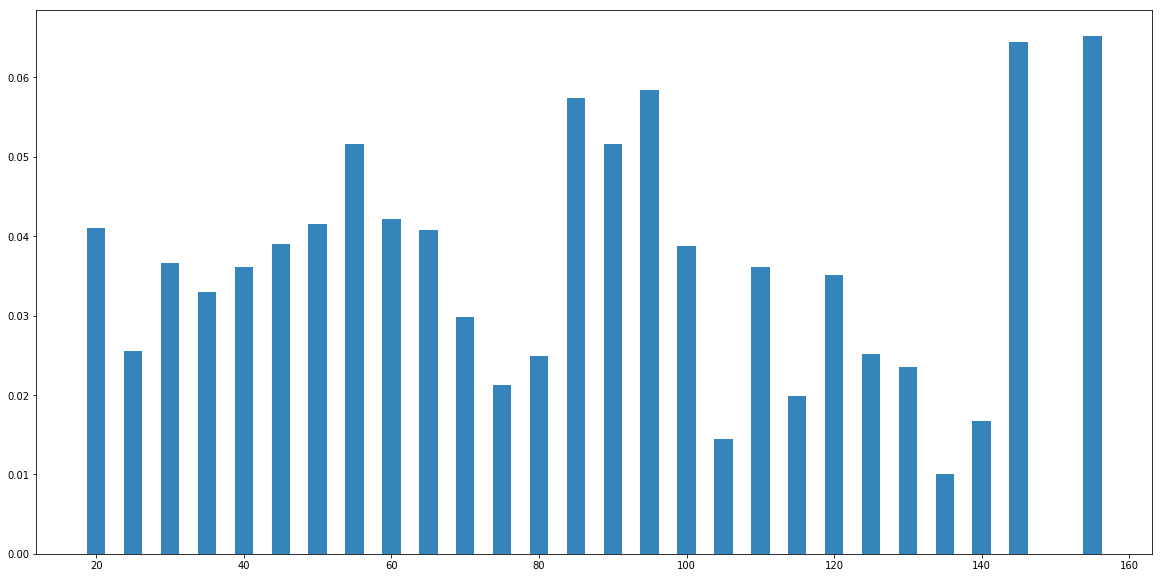

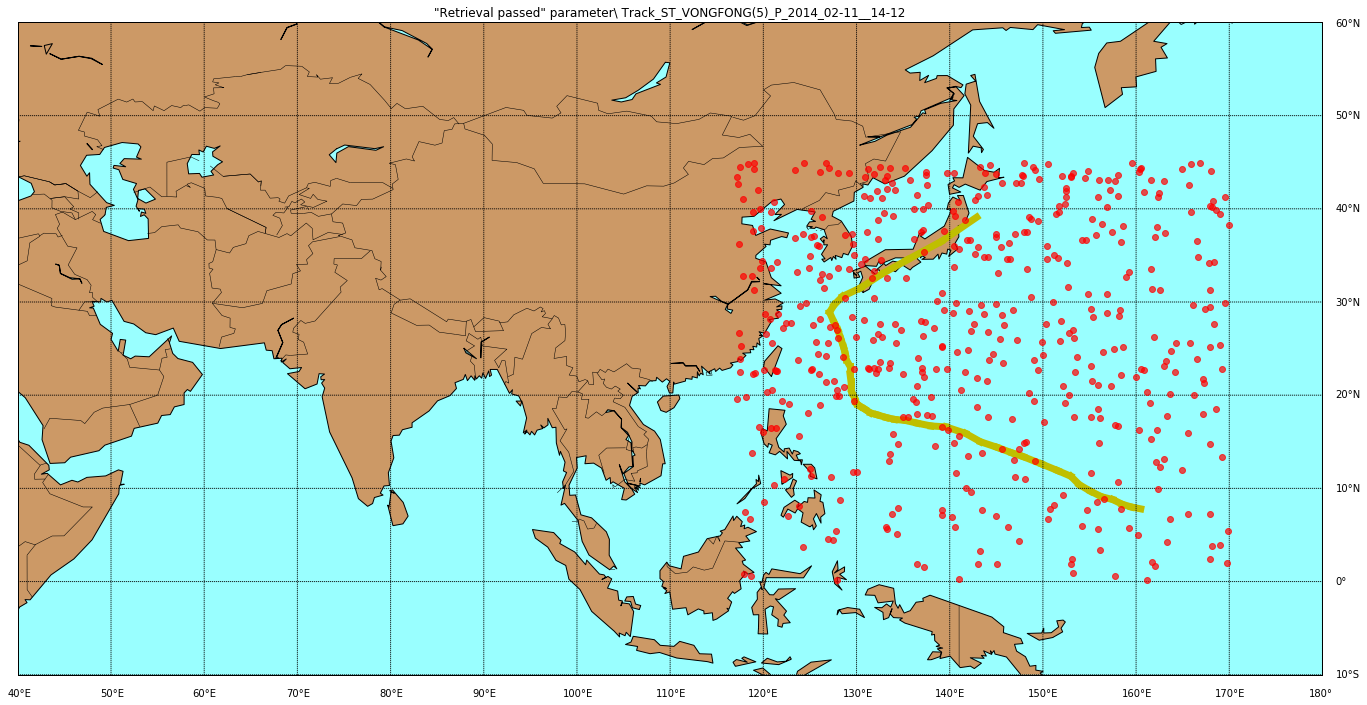

In [249]:
#set size figure
plt.figure(figsize=(24,12))

# create and set basemap
m = Basemap(llcrnrlon=40.,llcrnrlat=-10.,urcrnrlon=180.,urcrnrlat=60.)
#m = Basemap(llcrnrlon=30.,llcrnrlat=-20.,urcrnrlon=90.,urcrnrlat=50.)

for line in lines:
    m.plot(line[0], line[1], color='y', linewidth = 7)
    
m.drawcoastlines()
m.drawcountries()
m.drawmapboundary(fill_color='#99ffff')
m.fillcontinents(color='#cc9966',lake_color='#99ffff')
#m.drawparallels(np.arange(10,70,20),labels=[1,1,0,0])
#m.drawmeridians(np.arange(-100,0,20),labels=[0,0,0,1])
parallels = np.arange(90.,-81,-10.)
# labels = [left,right,top,bottom]
m.drawparallels(parallels,labels=[False,True,True,False])
meridians = np.arange(0.,351.,10.)
m.drawmeridians(meridians,labels=[True,False,False,True])

# plot
plt.scatter(point[:, 1], point[:, 0], c='red', alpha=0.7, zorder = 10)
#Error probability of a 
plt.title('"Retrieval passed" parameter\ Track_ST_VONGFONG(5)_P_2014_02-11__14-12')
plt.show()

In [256]:
result_np = np.zeros((0, 2))

for file in tqdm(files):
    try:
        extract_np = extract_prob_wind(file)
    except ValueError:
        print ("Exception with extract data. File: " + file)
        continue
    
    if extract_np.shape == (0, ):
        continue
    
    try:
        result_np = np.vstack((result_np, extract_np))
    except ValueError:
        print (result_np.shape, extract_np.shape)
    
result_np

 10%|████▍                                      | 8/78 [00:32<04:43,  4.05s/it]

Exception with extract data. File: Result_py\Hurricane\track_c_jack(2)_i_2014_18-04__22-04.csv


 12%|████▉                                      | 9/78 [01:23<10:39,  9.27s/it]

Exception with extract data. File: Result_py\Hurricane\track_c_kate(3)_2014_25-12__31-12.csv


 49%|████████████████████▍                     | 38/78 [02:26<02:34,  3.85s/it]

Exception with extract data. File: Result_py\Hurricane\track_td_fourteen_p_2014_07-09__08-09.csv


 51%|█████████████████████▌                    | 40/78 [02:27<02:19,  3.68s/it]

Exception with extract data. File: Result_py\Hurricane\track_td_sixteen_e_p_2014_11-09__14-09.csv


 55%|███████████████████████▏                  | 43/78 [02:28<02:01,  3.46s/it]

Exception with extract data. File: Result_py\Hurricane\track_ts_bakung_i_2014_11-12__13-12.csv


 58%|████████████████████████▏                 | 45/78 [02:29<01:49,  3.32s/it]

Exception with extract data. File: Result_py\Hurricane\track_ts_dolly_а_2014_01-09__04-09.csv


 62%|█████████████████████████▊                | 48/78 [02:31<01:34,  3.15s/it]

Exception with extract data. File: Result_py\Hurricane\track_ts_edna_p_2014_04-02__05-02.csv


 63%|██████████████████████████▍               | 49/78 [02:31<01:29,  3.09s/it]

Exception with extract data. File: Result_py\Hurricane\track_ts_elida_p_2014_30-06__02-07.csv


 76%|███████████████████████████████▊          | 59/78 [02:41<00:51,  2.73s/it]

Exception with extract data. File: Result_py\Hurricane\track_ts_ivanoe_i_2014_04-04__06-04.csv


 77%|████████████████████████████████▎         | 60/78 [02:41<00:48,  2.69s/it]

Exception with extract data. File: Result_py\Hurricane\track_ts_jangmi_p_2014_28-12__31-12.csv


 82%|██████████████████████████████████▍       | 64/78 [02:43<00:35,  2.55s/it]

Exception with extract data. File: Result_py\Hurricane\track_ts_kofi_p_2014_01-03__03-03.csv


 83%|███████████████████████████████████       | 65/78 [02:43<00:32,  2.52s/it]

Exception with extract data. File: Result_py\Hurricane\track_ts_lingling_p_2014_18-01__19-01.csv


 85%|███████████████████████████████████▌      | 66/78 [02:44<00:29,  2.49s/it]

Exception with extract data. File: Result_py\Hurricane\track_ts_nakri_p_2014_02-08__03-08.csv


 87%|████████████████████████████████████▌     | 68/78 [02:45<00:24,  2.43s/it]

Exception with extract data. File: Result_py\Hurricane\track_ts_one_i_2014_04-01__05-01.csv


 90%|█████████████████████████████████████▋    | 70/78 [02:47<00:19,  2.39s/it]

Exception with extract data. File: Result_py\Hurricane\track_ts_sinlaku_p_2014_26-10__29-10.csv


 92%|██████████████████████████████████████▊   | 72/78 [02:48<00:14,  2.33s/it]

Exception with extract data. File: Result_py\Hurricane\track_ts_two_i_2014_28-11__29-11.csv


100%|██████████████████████████████████████████| 78/78 [02:58<00:00,  2.29s/it]


array([['0.14285714285714285', '110.0'],
       ['0.23076923076923078', '90.0'],
       ['0.0', '75.0'],
       ..., 
       ['0.0', '45.0'],
       ['0.0', '45.0'],
       ['0.0', '25.0']],
      dtype='<U32')

In [257]:
plot_np = result_np[result_np[:, 1] != '-']
plot_df = pd.DataFrame(plot_np)

In [258]:
plot_df[0] = plot_df[0].map(lambda x: float(x))
plot_df[1] = plot_df[1].map(lambda x: float(x))

plot_np = plot_df.groupby(1).mean().values

In [259]:
plot_mean_df = plot_df.groupby(1).mean()
plot_mean_df['wind'] = plot_mean_df.index

plot_np = plot_mean_df.values

In [260]:
plot_np

array([[  4.10779696e-02,   2.00000000e+01],
       [  2.56024986e-02,   2.50000000e+01],
       [  3.65945803e-02,   3.00000000e+01],
       [  3.30167349e-02,   3.50000000e+01],
       [  3.61148982e-02,   4.00000000e+01],
       [  3.90400569e-02,   4.50000000e+01],
       [  4.15922018e-02,   5.00000000e+01],
       [  5.15951679e-02,   5.50000000e+01],
       [  4.22207761e-02,   6.00000000e+01],
       [  4.08137064e-02,   6.50000000e+01],
       [  2.97820410e-02,   7.00000000e+01],
       [  2.12864807e-02,   7.50000000e+01],
       [  2.49758376e-02,   8.00000000e+01],
       [  5.74205526e-02,   8.50000000e+01],
       [  5.16033959e-02,   9.00000000e+01],
       [  5.84722427e-02,   9.50000000e+01],
       [  3.88209829e-02,   1.00000000e+02],
       [  1.44008848e-02,   1.05000000e+02],
       [  3.61757003e-02,   1.10000000e+02],
       [  1.98611167e-02,   1.15000000e+02],
       [  3.50614959e-02,   1.20000000e+02],
       [  2.51367606e-02,   1.25000000e+02],
       [  

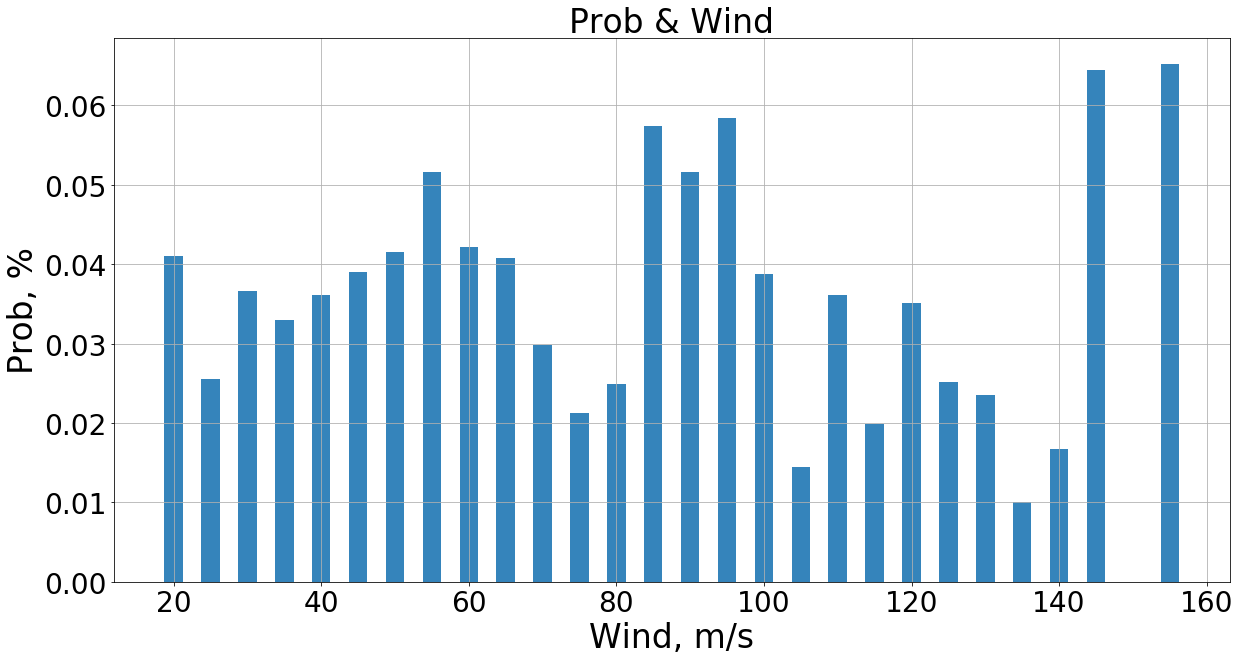

In [270]:
plot_np = plot_np[plot_np[:, 1].argsort()]

fig = plt.figure(figsize=(20, 10))

plt.bar(plot_np[:, 1], plot_np[:, 0], width=2.50, alpha=0.9)

plt.xlabel('Wind, m/s', fontsize=33)
plt.ylabel('Prob, %', fontsize=33)
plt.title('Prob & Wind', fontsize=33)
matplotlib.rc('xtick', labelsize=28)
matplotlib.rc('ytick', labelsize=28) 
plt.grid()
#fig.set_xlabel(u'Wind, km/h')
#fig.set_ylabel(u'P, %')
#fig.set_title(u'Ветер-Вероятность события')

plt.show()

Extract points of Ion.corr


100%|███████████████████████████████████████| 365/365 [00:00<00:00, 515.06it/s]


Extract all points


100%|███████████████████████████████████████| 365/365 [00:00<00:00, 441.37it/s]


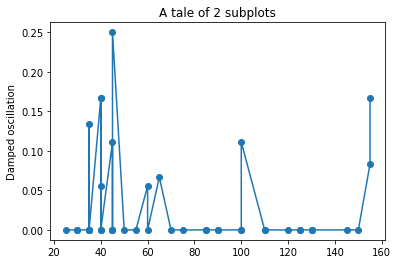

In [156]:
path_hurricane = "Result_py/Hurricane/track_st_hagupit(5)_p_2014_01-12__12-12.csv"

result_np = extract_prob_wind(path_hurricane)
result_np = result_np[result_np[:,1].argsort()]

plt.plot(result_np[:, 1], result_np[:, 0], 'o-')
plt.title('A tale of 2 subplots')
plt.ylabel('Damped oscillation')

plt.show()

C:\Users\Ignatov K\Anaconda3\lib\site-packages\mpl_toolkits\basemap\__init__.py:1708: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
C:\Users\Ignatov K\Anaconda3\lib\site-packages\mpl_toolkits\basemap\__init__.py:1711: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:


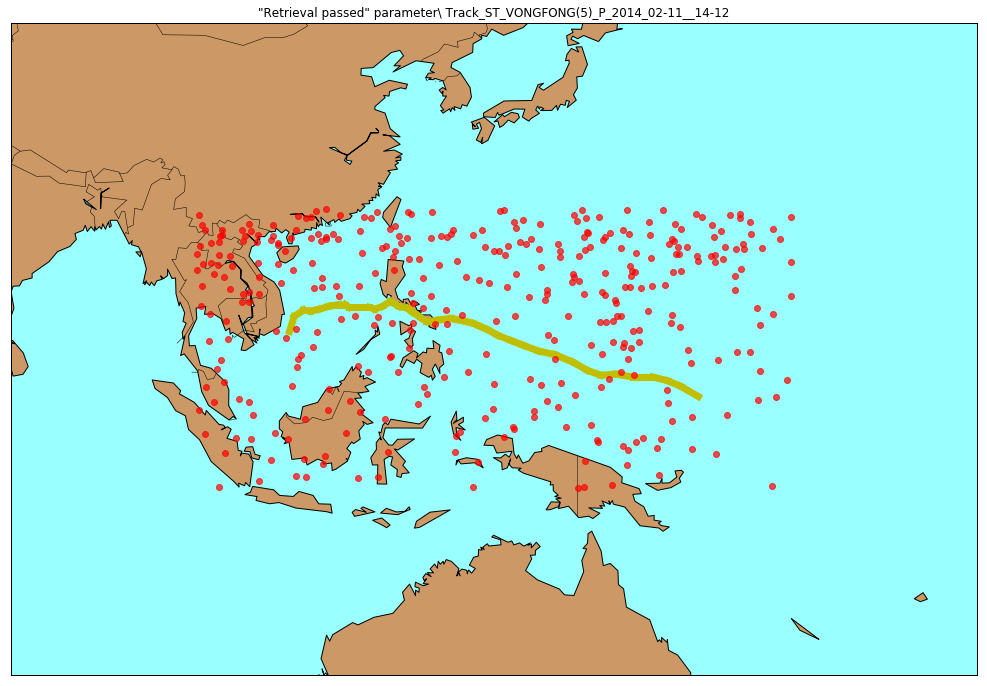

In [149]:
#set size figure
plt.figure(figsize=(24,12))

# create and set basemap
m = Basemap(llcrnrlon=lon_min - 20.,llcrnrlat=lat_min - 20.,urcrnrlon=lon_max + 20.,urcrnrlat=lat_max + 20.)

for line in lines:
    m.plot(line[0], line[1], color='y', linewidth = 7)
    
m.drawcoastlines()
m.drawcountries()
m.drawmapboundary(fill_color='#99ffff')
m.fillcontinents(color='#cc9966',lake_color='#99ffff')

parallels = np.arange(lon_min, lon_max, 10.)
m.drawparallels(parallels,labels=[False,True,True,False])

meridians = np.arange(lat_min, lat_max, 10.)
m.drawmeridians(meridians,labels=[True,False,False,True])

# plot
plt.scatter(point[:, 1], point[:, 0], c='red', alpha=0.7, zorder = 10)
#Error probability of a 
plt.title('"Retrieval passed" parameter\ Track_ST_VONGFONG(5)_P_2014_02-11__14-12')
plt.show()